## Imports

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms
from sklearn import preprocessing

root_dir = '../input/kaggle-pog-series-s01e03/corn'
train_labels_file = os.path.join(root_dir, 'train.csv')
test_labels_file =  os.path.join(root_dir, 'test.csv')
resolution = (140, 140)

## Shape Analysis
Before we do any further analysis, we should look at the size distribution, to find a suitable option that later models can use.

In [2]:
img_shapes = []
for file in glob.glob(root_dir + '/**/*.png', recursive=True):
    img = read_image(file)
    size = img.size()
    img_shapes.append(size[1:])

              width        height
count  17801.000000  17801.000000
mean     143.697714    143.631650
std       19.182155     18.538381
min       86.000000     84.000000
25%      132.000000    132.000000
50%      140.000000    140.000000
75%      152.000000    152.000000
max      228.000000    224.000000
The smallest image has shape 92 by 84
The largest image has shape 224 by 180


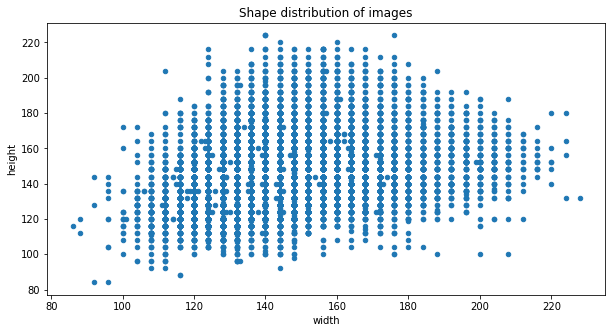

In [3]:
df = pd.DataFrame(img_shapes, columns=('width', 'height'))
print(df.describe())
print('=========================================')

df['prod'] = df['width'] * df['height']
min_shape = df.loc[df['prod'] == df['prod'].min()]
max_shape = df.loc[df['prod'] == df['prod'].max()]
print(f'The smallest image has shape {min_shape["width"].values[0]} by {min_shape["height"].values[0]}')
print(f'The largest image has shape {max_shape["width"].values[0]} by {max_shape["height"].values[0]}')
print('=========================================')

df.plot(kind='scatter', x='width', y='height', figsize=(10, 5),)
plt.title('Shape distribution of images')
plt.show()

### Observations
We can see that the average width and height is around 143 px with the median located at 140 px. The smallest image has shape 92 by 84 and the largest has the shape 224 by 180.

A suitable size for resizing all images seems to be the median, so we choose the size of (140, 140) for further analysis. This causes roughly the same amount of downscaling and upscaling.

## Create PyTorch Dataset

In [4]:
class CornDataset(Dataset):
    def __init__(self, label_file, root_dir, transform=nn.Identity(), is_train=True):
        self.is_train = is_train
        self.img_labels = pd.read_csv(label_file)
        if is_train:
            self.encoder = preprocessing.LabelEncoder()
            self.img_labels['label'] = self.encoder.fit_transform(self.img_labels['label'])
        self.root_dir = root_dir
        self.transform = transforms.Compose([transforms.Resize(resolution), transform])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_labels.iloc[idx, 2])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.is_train:
            label = self.img_labels.iloc[idx, 3]
            return image, label
        return image

In [5]:
train_ds = CornDataset(train_labels_file, root_dir)
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_ds = CornDataset(test_labels_file, root_dir, is_train=False)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 140, 140])
Labels batch shape: 64


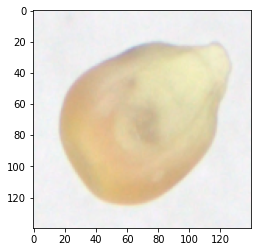

Label: pure


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[0].permute(1,2,0).numpy()
label = train_ds.encoder.inverse_transform([train_labels[0]])[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Define a simple baseline model
We will use a simple CNN to act as our baseline and verify our approach.

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # shape [3, 140, 140]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        # shape [16, 140, 140]
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        # shape [32, 140, 140]
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # shape [32, 70, 70]
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        # shape [64, 70, 70]
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        # shape [128, 70, 70]
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # shape [128, 35, 35]
        self.fc1 = nn.Linear(128 * 35 * 35, 1024)
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool2(x)
        
        x = x.view(-1, 128 * 35 * 35)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x

## Train the neural net

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

model = ConvNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Using device cuda
[1,   100] loss: 0.067
[1,   200] loss: 0.067
[2,   100] loss: 0.067
[2,   200] loss: 0.067
Finished Training


In [9]:
dataiter = iter(test_dataloader)
images = next(dataiter)
images = images.to(device)
model(images.float())

tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0.,